## Quantum Implementation of Travelling Salesman Problem : Optimizing QCBO (Constrained QUBO) using Quantum Annealing

### Getting Started

This notebook is dedicated to a QUBO implementation of the Travelling Salesman Problem (TSP) using D-Wave's Ocean suite package. The model is implemented as a Constrained Quadratic Model (CQM). The overall implementation is in three parts :

1)  Decision variables : Define the binary variables for visiting the nodes (i.e. $X$<sub>12</sub> = 1 means going from node 1 to node 2). For N nodes, there will be $N$ x $N-1$ binary variables.

2)  Objective function : Define the objective (minimize the overall distance $\sum_{i=1}^{N}$ $\sum_{j!=i, j=1}^{N}$ $X$<sub>ij</sub> $C$<sub>ij</sub> where $C$<sub>ij</sub> is the distance from i to j ($C$<sub>ij</sub> is not necessarily equal to $C$<sub>ji</sub> as in real world problems, the distances are non-euclidean and depend on roads))

3)  Constraints : Define the constraints 
    - (Only enter each node once and exit from each node once (visit each node once) $\sum_{i=1, i!=j}^{N}$ $X$<sub>ij</sub> = 1 for $j = 1, ... , N$ and $\sum_{j=1, j!=i}^{N}$ $X$<sub>ij</sub> = 1 for $i = 1, ... , N$.
    - Furthermore, we must have ONE route visiting all nodes and coming back, also known as a Hamiltonian cycle, and we model this using the Dantzig–Fulkerson–Johnson (DFJ) formulation of Subtour Elimintation Constraint as $\sum_{i\in Q}^{N}$ $\sum_{j!=i, j\in Q}^{N}$ $X$<sub>ij</sub> $\le |Q|-1$ for $∀Q \subseteq ${1, ..., N}$, |Q| \ge 2$

<p style="text-align:center;"><img src="tsp.png" alt="TSP"></p>
<p style="text-align:center;"> Figure 1 : Travelling the USA using TSP </p>

In [4]:
import os

from dimod.serialization.format import Formatter

os.chdir('..')
import dwave
from dimod import ConstrainedQuadraticModel, Binary, quicksum
from dwave.system import LeapHybridCQMSampler
import numpy as np
import itertools
from matplotlib import pyplot as plt

print("All packages imported successfully!")

All packages imported successfully!


We will implement some helper functions for finding the Q list which is a list of all subsets of {1, ... , N}, and findining the distance between nodes if no distance matrix is defined beforehand.

- containsNumber(value) : A helper function for extracting the numbers from a string for plotting purposes, for instance if $X$<sub>$12$</sub> is equal to 1, we would like to extract the sequence [1,2] from the variable. The parameter is a string, i.e. "$X$<sub>$12$</sub>".

- findsubsets(s, n) : A helper function for generating the subsets of a list s given a fixed size n.

- find_all_subsets(s) : A helper function for generating all subsets of a list s using findsubsets function.

- distance_between_points : A helper function for calculating the Euclidean distance between two points in a two-dimensional space.

In [2]:
def containsNumber(value):
    num_list = []
    for character in value:
        if character.isdigit():
            num_list.append(int(character) - 1)
    return num_list


# Function to generate the subsets of a list given size
def findsubsets(s, n):
    return list(itertools.combinations(s, n))


# Function to generate all the subsets of a list
def find_all_subsets(s):
    subtours = []
    temp_list = []
    for i in range(2, len(s)):
        temp_list = findsubsets(s, i)
        for j in range(len(temp_list)):
            subtours.append(temp_list[j])
    return subtours


# Function for calculating the euclidean distance
def distance_between_points(point_A, point_B):
    return np.sqrt((point_A[0] - point_B[0]) ** 2 + (point_A[1] - point_B[1]) ** 2)

We will initialize a CQM instance for creating the QCBO model.

In [51]:
# Initializing the CQM
cqm = ConstrainedQuadraticModel()

We will initialize the objective for the QCBO model.

In [52]:
# Initializing the objective
objective = 0

We will initialize the constraints for the QCBO model. There will be three constraints :

- Only enter each node once
- Only exit from each node once
- Visit all nodes

In [53]:
# Initializing the constraints
constraint_1 = 0
constraint_2 = 0
constraint_3 = 0

We will define the list of nodes' coordinates (this step is not necessary if you already have the distance matrix).

In [54]:
# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

x_vals = coordinates[:, 0]
y_vals = coordinates[:, 1]

We will generate the list of all node indices for generating the subsets.

In [55]:
# Number of nodes
n = len(coordinates)
global_set = [i for i in range(n)]

In [56]:
# List of subtours
subtours = find_all_subsets(global_set)
print(subtours)

# Number of subsets
S = len(subtours)
print(S)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 1, 5), (0, 2, 3), (0, 2, 4), (0, 2, 5), (0, 3, 4), (0, 3, 5), (0, 4, 5), (1, 2, 3), (1, 2, 4), (1, 2, 5), (1, 3, 4), (1, 3, 5), (1, 4, 5), (2, 3, 4), (2, 3, 5), (2, 4, 5), (3, 4, 5), (0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 2, 5), (0, 1, 3, 4), (0, 1, 3, 5), (0, 1, 4, 5), (0, 2, 3, 4), (0, 2, 3, 5), (0, 2, 4, 5), (0, 3, 4, 5), (1, 2, 3, 4), (1, 2, 3, 5), (1, 2, 4, 5), (1, 3, 4, 5), (2, 3, 4, 5), (0, 1, 2, 3, 4), (0, 1, 2, 3, 5), (0, 1, 2, 4, 5), (0, 1, 3, 4, 5), (0, 2, 3, 4, 5), (1, 2, 3, 4, 5)]
56


We will generate the distance matrix from the list of coordinates using a helper function (in this example we are using a Euclidean distance calculator).

In [57]:
# Distance Matrix
Distance_matrix = []
temp_set = []

# Generating the distance matrix
for i in range(n):
    for j in range(n):
        temp_set.append(distance_between_points(coordinates[i], coordinates[j]))
    Distance_matrix.append(temp_set)
    temp_set = []
print(Distance_matrix)

[[0.0, 2.23606797749979, 2.23606797749979, 3.1622776601683795, 4.0, 5.385164807134504], [2.23606797749979, 0.0, 1.4142135623730951, 1.0, 2.23606797749979, 3.1622776601683795], [2.23606797749979, 1.4142135623730951, 0.0, 2.23606797749979, 3.605551275463989, 4.0], [3.1622776601683795, 1.0, 2.23606797749979, 0.0, 1.4142135623730951, 2.23606797749979], [4.0, 2.23606797749979, 3.605551275463989, 1.4142135623730951, 0.0, 2.23606797749979], [5.385164807134504, 3.1622776601683795, 4.0, 2.23606797749979, 2.23606797749979, 0.0]]


We can alternatively use a pre-made distance matrix and skip the step above.

In [10]:
# Example distance matrix for 17 nodes
Distance_matrix = [[0, 633, 257,  91, 412, 150,  80, 134, 259, 505, 353, 324,  70, 211, 268, 246, 121],
                 [633, 0, 390, 661, 227, 488, 572, 530, 555, 289, 282, 638, 567, 466, 420, 745, 518],
                 [257, 390,   0, 228, 169, 112, 196, 154, 372, 262, 110, 437, 191,  74,  53, 472, 142],
                  [91, 661, 228,   0, 383, 120,  77, 105, 175, 476, 324, 240,  27, 182, 239, 237,  84],
                 [412, 227, 169, 383,   0, 267, 351, 309, 338, 196,  61, 421, 346, 243, 199, 528, 297],
                 [150, 488, 112, 120, 267,   0,  63,  34, 264, 360, 208, 329,  83, 105, 123, 364,  35],
                  [80, 572, 196,  77, 351,  63,   0,  29, 232, 444, 292, 297,  47, 150, 207, 332,  29],
                 [134, 530, 154, 105, 309,  34,  29,   0, 249, 402, 250, 314,  68, 108, 165, 349,  36],
                 [259, 555, 372, 175, 338, 264, 232, 249,   0, 495, 352,  95, 189, 326, 383, 202, 236],
                 [505, 289, 262, 476, 196, 360, 444, 402, 495,   0, 154, 578, 439, 336, 240, 685, 390],
                 [353, 282, 110, 324,  61, 208, 292, 250, 352, 154,   0, 435, 287, 184, 140, 542, 238],
                 [324, 638, 437, 240, 421, 329, 297, 314,  95, 578, 435,   0, 254, 391, 448, 157, 301],
                  [70, 567, 191,  27, 346,  83,  47,  68, 189, 439, 287, 254,   0, 145, 202, 289,  55],
                 [211, 466,  74, 182, 243, 105, 150, 108, 326, 336, 184, 391, 145,   0,  57, 426, 96],
                 [268, 420,  53, 239, 199, 123, 207, 165, 383, 240, 140, 448, 202,  57,   0, 483, 153],
                 [246, 745, 472, 237, 528, 364, 332, 349, 202, 685, 542, 157, 289, 426, 483,  0, 336],
                 [121, 518, 142,  84, 297,  35,  29,  36, 236, 390, 238, 301,  55,  96, 153, 336,  0]]

In [11]:
# Example distance matrix for 15 nodes
Distance_matrix = [[0, 29, 82, 46, 68, 52, 72, 42, 51, 55, 29, 74, 23, 72, 46],
                   [29, 0, 55, 46, 42, 43, 43, 23, 23, 31, 41, 51, 11, 52, 21],
                   [82, 55, 0, 68, 46, 55, 23, 43, 41, 29, 79, 21, 64, 31, 51],
                   [46, 46, 68, 0, 82, 15, 72, 31, 62, 42, 21, 51, 51, 43, 64],
                   [68, 42, 46, 82, 0, 74, 23, 52, 21, 46, 82, 58, 46, 65, 23],
                   [52, 43, 55, 15, 74, 0, 61, 23, 55, 31, 33, 37, 51, 29, 59],
                   [72, 43, 23, 72, 23, 61, 0, 42, 23, 31, 77, 37, 51, 46, 33],
                   [42, 23, 43, 31, 52, 23, 42, 0, 33, 15, 37, 33, 33, 31, 37],
                   [51, 23, 41, 62, 21, 55, 23, 33, 0, 29, 62, 46, 29, 51, 11],
                   [55, 31, 29, 42, 46, 31, 31, 15, 29, 0, 51, 21, 41, 23, 37],
                   [29, 41, 79, 21, 82, 33, 77, 37, 62, 51, 0, 65, 42, 59, 61],
                   [74, 51, 21, 51, 58, 37, 37, 33, 46, 21, 65, 0, 61, 11, 55],
                   [23, 11, 64, 51, 46, 51, 51, 33, 29, 41, 42, 61, 0, 62, 23],
                   [72, 52, 31, 43, 65, 29, 46, 31, 51, 23, 59, 11, 62, 0, 59],
                   [46, 21, 51, 64, 23, 59, 33, 37, 11, 37, 61, 55, 23, 59, 0]]

We will define the binary variables and add them to our objective function alongside their costs based on the distance matrix.

In [58]:
# Initializing the decision var
X_ = []

# Objective
for i in range(n):
    for j in range(n):
        if i == j:
            X_.append(0)
        else:
            X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
    objective += quicksum(Distance_matrix[j][i] * X_[j] for j in range(n))
    cqm.set_objective(objective)
    X_.clear()

In [59]:
# Assignment Constraints (Only one entry and exit per node)
for i in range(n):
    for j in range(n):
        if i == j:
            X_.append(0)
        else:
            X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
    constraint_1 = quicksum(X_[j] for j in range(n))
    cqm.add_constraint(constraint_1 == 1, label="Constraint 1-" + str(i + 1))
    X_.clear()

In [60]:
for j in range(n):
    for i in range(n):
        if i == j:
            X_.append(0)
        else:
            X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
    constraint_2 = quicksum(X_[i] for i in range(n))
    cqm.add_constraint(constraint_2 == 1, label="Constraint 2-" + str(j + 1))
    X_.clear()

In [61]:
# subtour elimination constraint
for s in range(S):  # s = {1,2}, length of s = 1, so 1 iterations of below
    for i in (subtours[s]):  # len of subtour = 2, so 2 iterations
        for j in (subtours[s]):  # len of subtour = 2 so 2 iterations
            # possible X_ : X1,1 X1,2 X2,1 X2,2
            if i == j:
                continue  # X1,1 and X2,2 are not accepted
            else:
                X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
    constraint_3 = quicksum(X_[j] for j in range(len(X_)))
    cqm.add_constraint(constraint_3 <= len(subtours[s]) - 1, label="Constraint 3-" + str(s + 1))
    X_.clear()

In [62]:
# Running the sampler to get the sample set
cqm_sampler = LeapHybridCQMSampler()
sampleset = cqm_sampler.sample_cqm(cqm, label='CQM-TSP', time_limit=30)

In [63]:
# Printing the sample set
for c, cval in cqm.constraints.items():
    print(c, cval)
    
feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

sample = feasible_sampleset.first.sample
Formatter(width=1000).fprint(feasible_sampleset)

0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0 13.122417       1 arra...    True
19    1.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0 13.122417       1 arra...    True
20    0.0   0.0   0.0   1.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0 13.122417       1 arra...    True
21    0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0 13.122417       1 arra...    True
22    0.0   1.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0 13.122417       1 arra...    True
23    0.0   0.

In [64]:
for constraint in cqm.iter_constraint_data(sample):
    print(constraint.label, constraint.violation)

Constraint 1-1 0.0
Constraint 1-2 0.0
Constraint 1-3 0.0
Constraint 1-4 0.0
Constraint 1-5 0.0
Constraint 1-6 0.0
Constraint 2-1 0.0
Constraint 2-2 0.0
Constraint 2-3 0.0
Constraint 2-4 0.0
Constraint 2-5 0.0
Constraint 2-6 0.0
Constraint 3-1 -1.0
Constraint 3-2 0.0
Constraint 3-3 -1.0
Constraint 3-4 0.0
Constraint 3-5 -1.0
Constraint 3-6 0.0
Constraint 3-7 0.0
Constraint 3-8 -1.0
Constraint 3-9 -1.0
Constraint 3-10 -1.0
Constraint 3-11 -1.0
Constraint 3-12 -1.0
Constraint 3-13 -1.0
Constraint 3-14 0.0
Constraint 3-15 0.0
Constraint 3-16 0.0
Constraint 3-17 -1.0
Constraint 3-18 -1.0
Constraint 3-19 -2.0
Constraint 3-20 -1.0
Constraint 3-21 0.0
Constraint 3-22 -1.0
Constraint 3-23 -1.0
Constraint 3-24 -1.0
Constraint 3-25 0.0
Constraint 3-26 0.0
Constraint 3-27 -1.0
Constraint 3-28 -1.0
Constraint 3-29 -1.0
Constraint 3-30 0.0
Constraint 3-31 -1.0
Constraint 3-32 -2.0
Constraint 3-33 -1.0
Constraint 3-34 -1.0
Constraint 3-35 0.0
Constraint 3-36 0.0
Constraint 3-37 0.0
Constraint 3-38 -1

In [65]:
for c, v in cqm.constraints.items():
    print('lhs : ' + str(v.lhs.energy(sample)))
    print('rhs : ' + str(v.rhs))
    print('sense  : ' + str(v.sense))
    print("---")

lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Eq
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 1.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense.Le
---
lhs : 0.0
rhs : 1.0
sense  : Sense

In [66]:
sample_keys = sample.keys()
sample_solutions = []
for key in sample_keys:
    if sample.get(key) == 1:
        sample_solutions.append(key)
print(sample_solutions)

['X_1_3', 'X_2_4', 'X_3_2', 'X_4_6', 'X_5_1', 'X_6_5']


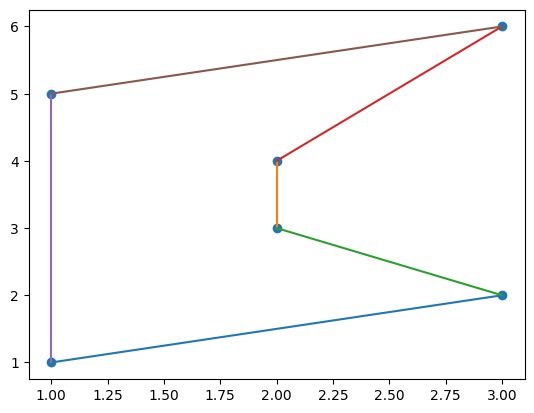

In [67]:
sample_coordinate_sequence = []
for i in range(len(sample_solutions)):
    res = containsNumber(sample_solutions[i])
    sample_coordinate_sequence.append(res)

plt.scatter(x_vals, y_vals)

for i in sample_coordinate_sequence:
    start = coordinates[i[0]]
    end = coordinates[i[1]]
    plt.plot([start[0], end[0]], [start[1], end[1]])

plt.show()

### Constructing the QTSP solver class

Now, we will package this into a QTSP class.

In [12]:
from __future__ import annotations
import itertools
from typing import Any

__all__ = ['QTSP']

from abc import ABC, abstractmethod
from collections.abc import Container, Iterable
import os
os.chdir('..')

from dimod.serialization.format import Formatter
from dimod import ConstrainedQuadraticModel, Binary, quicksum
from dwave.system import LeapHybridCQMSampler
import numpy as np
import itertools
from matplotlib import pyplot as plt


class QTSP(ABC):
    """ `QTSP` is a class for implementing a CQM for the Travelling Salesman Problem.

    Parameters
    ----------
    coordinates : Iterable[Iterable[float]]
        The coordinates of the nodes of the graph.
    time : int
        The time limit for the problem.
    log : bool
        Whether to log the output or not.
    """
    def __init__(self,
                 coordinates: Iterable[Iterable[float]],
                 time: int,
                 log: bool = True):
        self.coordinates = coordinates
        self.num_nodes = len(self.coordinates)
        self.time_limit = time
        self.log = log
        # Construct the CQM
        self.cqm = self.define_CQM()

    def define_distance_matrix(self):
        """ Function to define the distance matrix for the given coordinates.
        """
        # Distance Matrix
        Distance_matrix = []
        temp_set = []

        # Function for calculating the euclidean distance
        def distance_between_points(point_A, point_B):
            return np.sqrt((point_A[0] - point_B[0]) ** 2 + (point_A[1] - point_B[1]) ** 2)

        # Generating the distance matrix
        for i in range(len(self.coordinates)):
            for j in range(len(self.coordinates)):
                temp_set.append(distance_between_points(self.coordinates[i], self.coordinates[j]))
            Distance_matrix.append(temp_set)
            temp_set = []

        return Distance_matrix

    def generate_subtours(self):
        """ Function to generate the subtours for the given graph.
        """
        # Initialize subtours list
        subtours = []
        temp_list = []

        # Function to generate the subsets of a list given size
        def find_subsets(s, n):
            return list(itertools.combinations(s, n))

        for i in range(2, self.num_nodes):
            temp_list = find_subsets(range(self.num_nodes), i)
            for j in range(len(temp_list)):
                subtours.append(temp_list[j])
        return subtours

    def define_CQM(self):
        """ Function to define the CQM for the given graph.
        """
        # Construct the distance matrix
        Distance_matrix = self.define_distance_matrix()

        # Generate subtours
        subtours = self.generate_subtours()

        # Define the number of subtours
        S = len(subtours)

        # Initialize the CQM
        cqm = ConstrainedQuadraticModel()

        # Initialize the objective
        objective = 0

        # Initialize the constraints
        constraint_1 = 0
        constraint_2 = 0
        constraint_3 = 0

        # Initialize the decision var
        X_ = []

        # Define objective
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if i == j:
                    X_.append(0)
                else:
                    X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
            objective += quicksum(Distance_matrix[j][i] * X_[j] for j in range(self.num_nodes))
            cqm.set_objective(objective)
            X_.clear()

        # Define Constraints (Only one entry and exit per node)
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
                if i == j:
                    X_.append(0)
                else:
                    X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
            constraint_1 = quicksum(X_[j] for j in range(self.num_nodes))
            cqm.add_constraint(constraint_1 == 1, label="Constraint 1-" + str(i + 1))
            X_.clear()

        for j in range(self.num_nodes):
            for i in range(self.num_nodes):
                if i == j:
                    X_.append(0)
                else:
                    X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
            constraint_2 = quicksum(X_[i] for i in range(self.num_nodes))
            cqm.add_constraint(constraint_2 == 1, label="Constraint 2-" + str(j + 1))
            X_.clear()

        # Define subtour elimination constraint
        for s in range(S):  # s = {1,2}, length of s = 1, so 1 iterations of below
            for i in (subtours[s]):  # len of subtour = 2, so 2 iterations
                for j in (subtours[s]):  # len of subtour = 2 so 2 iterations
                    # possible X_ : X1,1 X1,2 X2,1 X2,2
                    if i == j:
                        continue  # X1,1 and X2,2 are not accepted
                    else:
                        X_.append(Binary('X_' + str(i + 1) + "_" + str(j + 1)))
            constraint_3 = quicksum(X_[j] for j in range(len(X_)))
            cqm.add_constraint(constraint_3 <= len(subtours[s]) - 1, label="Constraint 3-" + str(s + 1))
            X_.clear()

        return cqm

    def __call__(self):
        # Running the sampler to get the sample set
        cqm_sampler = LeapHybridCQMSampler()
        sampleset = cqm_sampler.sample_cqm(self.cqm, label='CQM-TSP', time_limit=self.time_limit)

        if self.log:
            # Printing the sample set
            for c, cval in self.cqm.constraints.items():
                print(c, cval)

        feasible_sampleset = sampleset.filter(lambda d: d.is_feasible)

        sample = feasible_sampleset.first.sample

        if self.log:
            Formatter(width=1000).fprint(feasible_sampleset)

            for constraint in self.cqm.iter_constraint_data(sample):
                print(constraint.label, constraint.violation)

            for c, v in self.cqm.constraints.items():
                print('lhs : ' + str(v.lhs.energy(sample)))
                print('rhs : ' + str(v.rhs))
                print('sense  : ' + str(v.sense))
                print("---")

        sample_keys = sample.keys()
        sample_solutions = []
        for key in sample_keys:
            if sample.get(key) == 1:
                sample_solutions.append(key)
        
        if self.log:
            print(sample_solutions)

        def containsNumber(value):
            num_list = []
            for character in value:
                if character.isdigit():
                    num_list.append(int(character) - 1)
            return num_list
    
        sample_coordinate_sequence = []
        for i in range(len(sample_solutions)):
            res = containsNumber(sample_solutions[i])
            sample_coordinate_sequence.append(res)

        plt.scatter(self.coordinates[:, 0], self.coordinates[:, 1])

        for i in sample_coordinate_sequence:
            start = self.coordinates[i[0]]
            end = self.coordinates[i[1]]
            plt.plot([start[0], end[0]], [start[1], end[1]])

        plt.show()

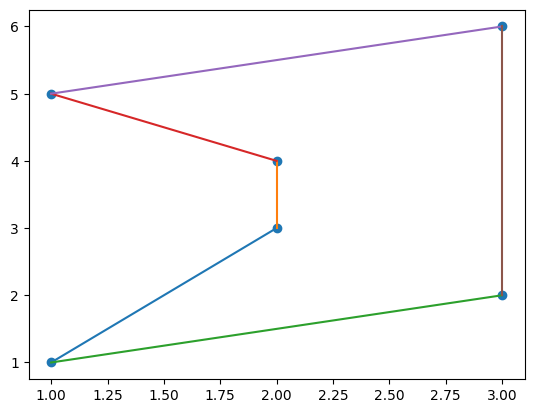

In [15]:
# List of coordinates
coordinates = np.array([[1, 1], [2, 3], [3, 2], [2, 4], [1, 5], [3, 6]])   # 6 nodes

tsp_model = QTSP(coordinates=coordinates, time=30, log=False)

tsp_model()

We can now simply create a class instance, and call it to run the TSP optimization, and extract the result.

## Final Thoughts

In this notebook, we went through a simple implementation of the Travelling Salesman Problem by formulating a Constrained Quadratic Model (CQM). This implementation can be further improved by defining the constraints more efficiently. Currently, the single visit constraint requires $2N$ constraints to implement, and the subtour elimination constraint requires $2^N - N - 2$ constraints to implement. This puts the overall number of constraints at $2^N + N -1$.



In [10]:
import ipywidgets as widgets
from IPython.display import display

def number_constraints(N: int) -> int:
    """
    Returns the number of constraints for a QUBO formulation of the
    Travelling Salesman Problem with N cities.
    """
    return 2**N - N - 2, 2*N

# Define the interactive widget function
def interactive_number_constraints():
    N_widget = widgets.IntSlider(
        value=5,
        min=2,
        max=15,
        step=1,
        description='Number of Cities (N):',
        style={'description_width': 'initial'}
    )

    svc_widget = widgets.Label()
    sec_widget = widgets.Label()
    result_widget = widgets.Label()

    def update_result(change):
        N = N_widget.value
        subtour_elimination_constraint, single_visit_constraint = number_constraints(N)
        constraints = single_visit_constraint + subtour_elimination_constraint
        svc_widget.value = f"Number of Constraints to implement the single node visit constraint: {single_visit_constraint}"
        sec_widget.value = f"Number of Constraints to implement the subtour elimination constraint: {subtour_elimination_constraint}"
        result_widget.value = f"Total number of Constraints: {constraints}"

    N_widget.observe(update_result, 'value')

    update_result(None)  # Initial update of the result widget

    # Display the widgets
    display(N_widget, svc_widget)
    display(sec_widget)
    display(result_widget)

# Call the interactive widget function to show it in the Jupyter Notebook
interactive_number_constraints()

IntSlider(value=5, description='Number of Cities (N):', max=15, min=2, style=SliderStyle(description_width='in…

Label(value='Number of Constraints to implement the single node visit constraint: 10')

Label(value='Number of Constraints to implement the subtour elimination constraint: 25')

Label(value='Total number of Constraints: 35')

The key focus in these implementations is to have as few binary variables, and constraints as possible, which will directly reduce the cost of mapping the model to D-Wave's QPU.

In the next notebook, we will do exactly that, and improve this rather inelegant implementation to be more efficient.

<br>

<p>© 2023 Amirali Malekani Nezhad, all rights reserved.</p>